In [9]:
# Unet is conditioned on time, can also condition on temp same way?
# In theory anything can replace the unet?

In [1]:
import mdshare
import mdtraj as md
import nglview as ng
import numpy as np

from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt


In [8]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')
trj = md.load(files, top=pdb)

back_idxs = trj.top.select("backbone")
back_trj = trj.atom_slice(back_idxs)
back_trj = back_trj.superpose(back_trj)

c = np.array([md.compute_phi(trj)[1], md.compute_psi(trj)[1]])[...,0].T
x = back_trj.xyz.reshape(c.shape[0], -1)

print(x.shape, c.shape)

(750000, 24) (750000, 2)


In [11]:
# save data to file for loading (based off image loader format)
# try limiting to 8 input atom for concistency

# condition on phi and psi
training_adp = np.concatenate([c[:500_000, :], x[:500_000, :]], axis=-1)
testing_adp = np.concatenate([c[500_000:, :], x[500_000:, :]], axis=-1)
test_adp_conditions =  testing_adp[:, :2]

np.save('./traj_AIB9/train_adp_traj.npy', training_adp)
np.save('./traj_AIB9/test_adp_traj.npy', testing_adp)
np.save('./traj_AIB9/test_adp_cond_traj.npy', test_adp_conditions)

print(training_adp.shape, testing_adp.shape, test_adp_conditions.shape)

(500000, 26) (250000, 26) (250000, 2)


In [6]:
%load_ext autoreload
%autoreload 2

from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Dataset_traj, cycle, num_to_groups

import torch
from torch import nn 

import sys, os
sys.path.append('./denoising_diffusion_pytorch')

from Unets_MJ import Unet_noattn, simple_MLP, simple_Conv, Unet_xyz
from Unets_pos_cond import Unet_cond

from denoising_diffusion_pytorch_1d_MJ import Unet1D, GaussianDiffusion1D, Trainer, Dataset_traj

print(os.getcwd())

device = torch.device("cuda")  #torch.device("cuda")

# define the U-net structure

model = Unet(dim = 32, dim_mults = (1, 2, 2, 4), groups = 8).to(device)
#model = Unet_noattn(dim = 32,dim_mults = (1, 2, 2, 4),groups = 8).to(device)
#model = simple_MLP(dim=32).to(device)
#model = simple_Conv(dim=32).to(device)

#model =  Unet_xyz(dim = 32, n_conds=n_srvs, dim_mults = (1, 2, 2, 4), groups = 8).to(device)

#model = Unet1D(32, dim_mults = (1, 2, 2, 4), channels=1)

model = nn.DataParallel(model)
model.to(device)

# define diffusion model
op_num = 30 + n_srvs      # override this to the mean the total number of features
konw_op_num = n_srvs  # passing in 0 means no masking

diffusion = GaussianDiffusion(
    model,                          # U-net model
    timesteps = 1000,               # number of diffusion steps
    unmask_number = konw_op_num,    # konw_op_num,  # the dimension of x2 in P(x1|x2)
    loss_type = 'l2'                # L1 or L2
).to(device)

#set training parameters
trainer = Trainer(
    diffusion,                                   # diffusion model
    folder = 'traj_AIB9',                        # folder of trajectories
    system = 'train_adp',         #'AIB9_REMD_T_full_100000ps_2.0ps',  # name of the trajectory, the file {system}_traj.npy will be used as the training set
    train_batch_size = 128,                      # training batch size
    train_lr = 1e-5,                             # learning rate
    train_num_steps = 1_000, #2000000,                   # total training steps
    gradient_accumulate_every = 1,               # gradient accumulation steps
    ema_decay = 0.995,                           # exponential moving average decay
    op_number = op_num,
    fp16 = False                                 # turn on mixed precision training with apex
)

# get model size:
m_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(m_size, 'parameters')

/project/andrewferguson/Mike/geometric_deep_learning/DDPM_REMD
1095209 parameters


In [7]:
%%time

# load trained model
#model_id = 30   # model 35 not included?  
#trainer.load(model_id, device=device)

# start training
trainer.train()

0: 1.2840596437454224


KeyboardInterrupt: 

In [9]:
#torch.save(model, './saved_models_MJ/100k-steps_van-unet')

torch.__version__

'1.7.1'

#**Generate samples**

To generate samples from distribtuion $P(x_1 |x_2)$, we need to provide samples about the conditional part $x_2$. 

In this example, it is relatively simple as we only need to privde the information about the temperature. 

In [17]:
#prepare a dataloader to give samples from the conditional part of the distribution
batch_size = 50_000  #1280  #the number of samples generated in each batch

sample_ds = Dataset_traj('traj_AIB9', 'test_cond', n_conds=konw_op_num) #'sample_T')
sample_ds.max_data = trainer.ds.max_data
sample_ds.min_data = trainer.ds.min_data    #To ensure that the sample data is scaled in the same way as the training data

# both shuffle and pin_memory og set to true
sample_dl = cycle(data.DataLoader(sample_ds, batch_size = batch_size, shuffle=False, pin_memory=False)) 

In [18]:
%load_ext autoreload
%autoreload 2

# generate samples for ADP

num_sample = 250_000 // test_stride #len(testing_adp_condition)  # total number of samples

batches = num_to_groups(num_sample, batch_size)
all_ops_list = list(map(lambda n: trainer.ema_model.sample(
    trainer.op_number, batch_size=n, samples = next(sample_dl).cuda()[:n, :]), batches))

all_ops = torch.cat(all_ops_list, dim=0).cpu()
all_ops = trainer.rescale_sample_back(all_ops)

np.save(str(trainer.RESULTS_FOLDER / f'samples-ADP'), all_ops.numpy())
print(str(trainer.RESULTS_FOLDER / f'samples-ADP.npy'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


sampling loop time step: 100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s]

results/train_adp/32-1-2-2-4-b128/given_2_op/samples-ADP.npy


In [25]:
print(type(sample_ds))
print(sample_ds.data.shape[0])

<class 'denoising_diffusion_pytorch.denoising_diffusion_pytorch.Dataset_traj'>
250000


In [19]:
# check test and sample psi/phi conditioning match
check_dist = False

if check_dist:

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    print(test_adp_conditions.shape, all_ops.shape)

    # phi
    axes[0, 0].hist(all_ops.numpy()[:, 0, 0], bins=30, density=True)
    axes[0, 0].hist(test_adp_conditions[:num_sample, 0], bins=30, alpha=0.5, density=True)
    axes[1, 0].scatter(all_ops.numpy()[:, 0, 0], test_adp_conditions[:num_sample, 0], s=1)

    # psi
    axes[0, 1].hist(all_ops.numpy()[:, 0, 1], bins=30, density=True)
    axes[0, 1].hist(test_adp_conditions[:num_sample, 1], bins=30, alpha=0.5, density=True)
    axes[1, 1].scatter(all_ops.numpy()[:, 0, 1], test_adp_conditions[:num_sample, 1], s=1)


(250000, 2)
Pearson Phi:   0.6991
Pearson Psi:   -0.8194
ks/pval Phi:   0.9591 0.0
ks/pval Psi:   0.7851 0.0


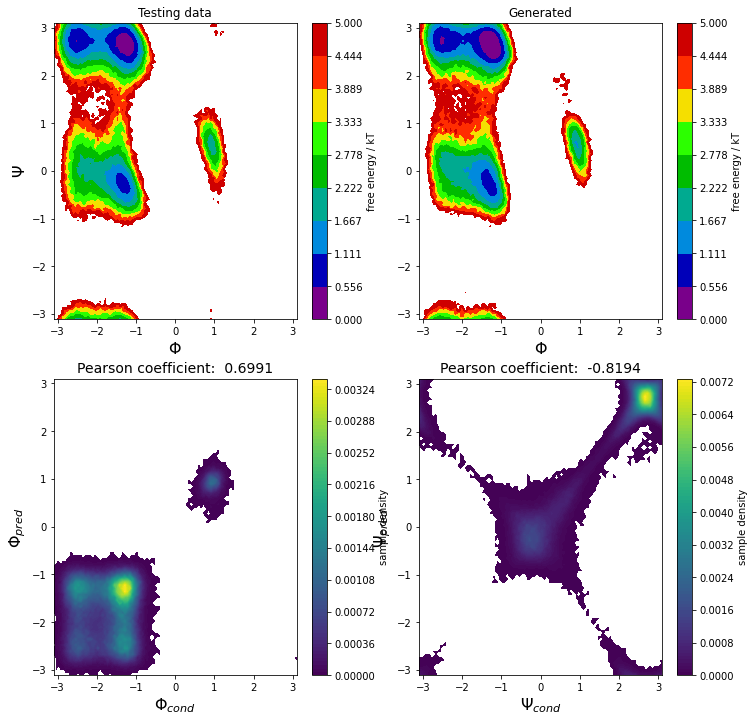

In [20]:
import pyemma as py
from scipy.stats import pearsonr, ks_2samp

pos_val = all_ops.numpy()[:, 0, konw_op_num:]

trj_val = md.Trajectory(pos_val.reshape(pos_val.shape[0], -1, 3), topology=heavy_trj.top)
c_val = np.concatenate((md.compute_phi(trj_val)[1], md.compute_psi(trj_val)[1]), -1)
print(c_val.shape)

fig, axes = plt.subplots(2, 2, figsize=(12, 12)) #, sharex=True, sharey=True)

py.plots.plot_free_energy(*c[500_000::test_stride][:num_sample].T, ax=axes[0, 0], levels=np.linspace(0, 5, 10))
py.plots.plot_free_energy(*c_val.T, ax=axes[0, 1], levels=np.linspace(0, 5, 10))

axes[0, 0].set_title('Testing data')
axes[0, 1].set_title('Generated')

axes[0, 0].set_ylabel(r'$\Psi$', fontsize=16)
axes[0, 0].set_xlabel(r'$\Phi$', fontsize=16)
axes[0, 1].set_xlabel(r'$\Phi$', fontsize=16)

#py.plots.plot_density(testing_adp[:num_sample, 0], c_val[:, 0], ax=axes[1, 0])
#py.plots.plot_density(testing_adp[:num_sample, 1], c_val[:, 1], ax=axes[1, 1])

# based on what it should be conditioned on:
py.plots.plot_density(c[500_000:, 0][::test_stride], c_val[:, 0], ax=axes[1, 0])
py.plots.plot_density(c[500_000:, 1][::test_stride], c_val[:, 1], ax=axes[1, 1])

axes[1, 0].set_xlabel(r'$\Phi_{cond}$', fontsize=16)
axes[1, 0].set_ylabel(r'$\Phi_{pred}$', fontsize=16)

axes[1, 1].set_xlabel(r'$\Psi_{cond}$', fontsize=16)
axes[1, 1].set_ylabel(r'$\Psi_{pred}$', fontsize=16)

# print correlation between condtions
p_phi, _ = pearsonr(testing_adp[:num_sample, 0], c_val[:, 0])
p_psi, _ = pearsonr(testing_adp[:num_sample, 1], c_val[:, 1])

ks_phi = ks_2samp(testing_adp[:num_sample, 0], c_val[:, 0])
ks_psi = ks_2samp(testing_adp[:num_sample, 1], c_val[:, 1])

axes[1, 0].set_title('Pearson coefficient:  ' + str(np.round(p_phi, 4)), fontsize=14)
axes[1, 1].set_title('Pearson coefficient:  ' + str(np.round(p_psi, 4)), fontsize=14)

print('Pearson Phi:  ', np.round(p_phi, 4))
print('Pearson Psi:  ', np.round(p_psi, 4))
print('ks/pval Phi:  ', np.round(ks_phi.statistic, 4), np.round(ks_phi.pvalue, 4))
print('ks/pval Psi:  ', np.round(ks_psi.statistic, 4), np.round(ks_psi.pvalue, 4))


In [ ]:
# test dim changes when going from flattened to multi-channel

B, N = 3, 5

arr = np.zeros((B, N, 3))

for b in range(B):
    for i in range(N):
        for j in range(3):
            arr[b, i, j] = (b+1)*100 + (i+1)*10 + (j+1)
        
arr_flat = arr.reshape(1, -1)
arr_flat = torch.tensor(arr_flat).unsqueeze(1)
print(arr_flat.shape)

arr_channels = arr_flat.reshape((-1, N, 3))
arr_channels = torch.swapaxes(arr_channels, 1, 2)

print(arr_channels.shape)
print(arr_channels)

# re-flatten correctly
arr_reflat = torch.swapaxes(arr_channels, 1, 2)
arr_reflat = arr_reflat.reshape((-1, N*3))

print(arr_reflat.shape)
print(arr_reflat)

B, C, N = 3, 2, 5

arr = np.zeros((B, 1, C))

for b in range(B):
    for c in range(C):
        arr[b, 0, c] = (b+1)*10 + (c+1)

arr = torch.tensor(arr)
print(arr.shape)
print(arr[0])

arr_layer = torch.swapaxes(arr, 1, 2).expand(-1, -1, N)
print(arr_layer.shape)
print(arr_layer[0])

arr_final = torch.cat([arr_channels, arr_layer], dim=1)
print(arr_final.shape)
print(arr_final[0])                     

(50000, 10, 3) (50000, 10, 3)
02-11-22 10:27:58 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[16] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


Check the output of describe() to see the actual order of the features


(50000, 45) (50000, 45)
0.4294926797271885 0.44440752901178004


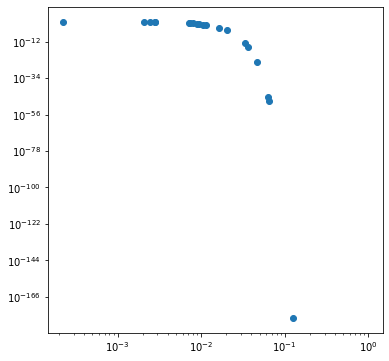

In [194]:
# compare distributions across all bond length/intermolecular distances

trj_org = heavy_trj[500_000::test_stride]
print(trj_org.xyz.shape, trj_val.xyz.shape)

# extract all intermolecular distance features
feat = py.coordinates.featurizer(trj_org.topology) 
feat.add_distances(np.arange(10))
feats_org = feat.transform(trj_org)
feats_val = feat.transform(trj_val)
print(feats_org.shape, feats_val.shape)

stat_list, p_list = [], []
for f_org, f_val in zip(feats_org.T, feats_val.T):
    
    #result = ks_2samp(f_val, f_org)
    #stat_list.append(result.statistic)
    #p_list.append(result.pvalue)
    
    stat, p = pearsonr(f_val, f_org)
    stat_list.append(stat)
    p_list.append(p)

fig, axes = plt.subplots(figsize=(6,6))
axes.scatter(stat_list, p_list)
axes.set_yscale('log')
axes.set_xscale('log')

print(np.mean(stat_list), np.std(stat_list))

Text(0.5, 0, 'Feature Index')

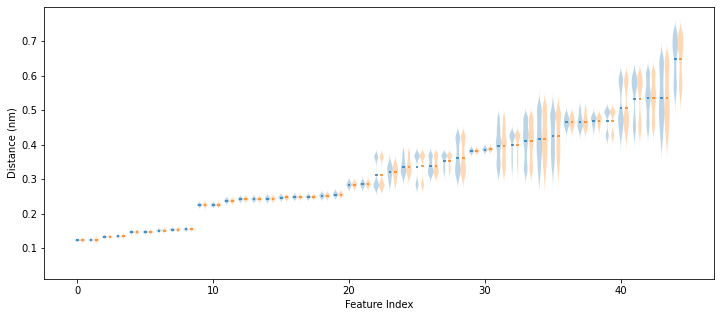

In [195]:
# compare each dist using Kolmagororov-Smirnow test

# sort by bond index
sort_idxs = np.argsort(feats_org.mean(axis=0))
feats_org = feats_org[:, sort_idxs]
feats_val = feats_val[:, sort_idxs]

fig, axes = plt.subplots(1, 1, figsize=(12, 5))
_ = axes.violinplot(feats_org, positions=np.arange(45), showmeans=True, showextrema=False, widths=0.4)
_ = axes.violinplot(feats_val, positions=np.arange(45)+0.4, showmeans=True, showextrema=False, widths=0.4)
axes.set_ylabel('Distance (nm)')
axes.set_xlabel('Feature Index')



In [105]:
# heavy_idxs
trj_test = trj[500_000::test_stride]

view = ng.NGLWidget() 
view.add_trajectory(trj_val)
view.add_trajectory(trj_test)
view

NGLWidget(max_frame=49999)

In [209]:
dim = 32
dim_mults=(1, 2, 4, 8)
dims = [1, *map(lambda m: dim * m, dim_mults)]
in_out = list(zip(dims[:-1], dims[1:]))


print(dims)
print(in_out)
print(time_pos_emb)

[1, 32, 64, 128, 256]
[(1, 32), (32, 64), (64, 128), (128, 256)]


NameError: name 'time_pos_emb' is not defined